## Часть 1
Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты. 

### Часть 2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательная визуализация. 

In [1]:
!pip install telethon

In [2]:
from telethon import TelegramClient
import configparser
import re
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
chat_id = str("Sputnik_results")
# add api hash and id
api_id = int()
api_hash = str()

In [4]:
client = TelegramClient('kas7par', api_id=api_id, api_hash=api_hash)
client.connect()
print("Successful connection")
messages = pd.DataFrame()
async with client:
    async for message in client.iter_messages(chat_id):
        sender = ""
        if (message.sender):
            sender = message.sender.first_name
        parded_info = {"Date": message.date, "Name": str(sender or ''), "Text": message.text}
        messages = messages.append(parded_info, ignore_index=True)
    print(messages)

messages.Date = pd.to_datetime(messages.Date)
messages.to_csv('messages.csv', encoding='utf-8', index=False)

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: coroutine 'TelegramBaseClient.connect' was never awaited
  """


Successful connection
                           Date         Name  \
0     2021-12-17 15:00:02+00:00  Republisher   
1     2021-12-17 14:30:04+00:00  Republisher   
2     2021-12-17 13:46:16+00:00      Надежда   
3     2021-12-17 13:09:43+00:00            И   
4     2021-12-17 12:44:23+00:00                
...                         ...          ...   
30712 2020-12-09 15:45:57+00:00       Галина   
30713 2020-12-09 15:45:53+00:00       Сергей   
30714 2020-12-09 15:45:45+00:00        Daria   
30715 2020-12-09 11:17:38+00:00    Ekaterina   
30716 2020-12-08 14:37:44+00:00                

                                                    Text  
0      **Народные отчеты о вакцинации\n\n**⚠️ **ТОЛЬК...  
1      🔴 Дорогие друзья! Вы уже знаете о появлении но...  
2      М71 \nПроблемы с сосудами ног. Оперированная г...  
3      Ж,25. Хронические заболевания: псориаз, псориа...  
4      Здесь вам никто не ответит, и.к. переписка в ч...  
...                                            

In [5]:
messages = pd.read_csv('messages.csv', encoding='utf-8')

Text(0, 0.5, 'Кол-во сообщений')

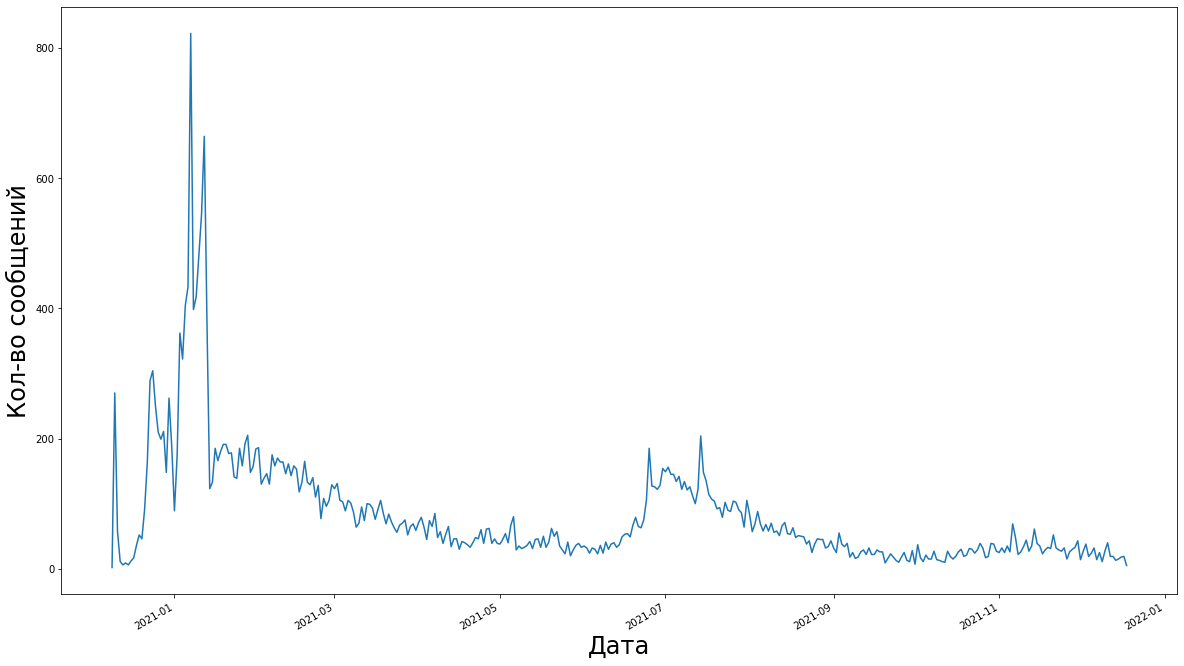

In [6]:
f = plt.figure(figsize=(20, 12))
messages.Date = pd.to_datetime(messages.Date)
messages.Date.dt.round(freq='D').value_counts().plot()
plt.xlabel('Дата', fontsize=24)
plt.ylabel('Кол-во сообщений', fontsize=24)

In [7]:
messages[['Gender', 'Age']] = messages['Text'].str.lower().str.extract(r'^(мужчина|женщина|[мж])[^а-яА-Я0-9a-zA-Z]*(\d*)', expand=True)
messages = messages.dropna()

# отбрасываем неидентифицированные строчки
messages = messages[messages.Age != '']
messages = messages[messages.Gender != '']

# отбрасываем шумовые значения
messages = messages[messages.Age.astype('float') <= 100]
messages = messages.reset_index(drop=True)

gender_map = {'м': "М", 'мужчина': "М", 'ж': "Ж", 'женщина': "Ж"}
messages['Gender'] = messages.Gender.map(gender_map)

messages.to_csv('messages_gender_age.csv', encoding='utf-8', index=False)

In [8]:
messages = pd.read_csv('messages_gender_age.csv', encoding='utf-8')

<AxesSubplot:xlabel='Пол', ylabel='Количество вакцинированных'>

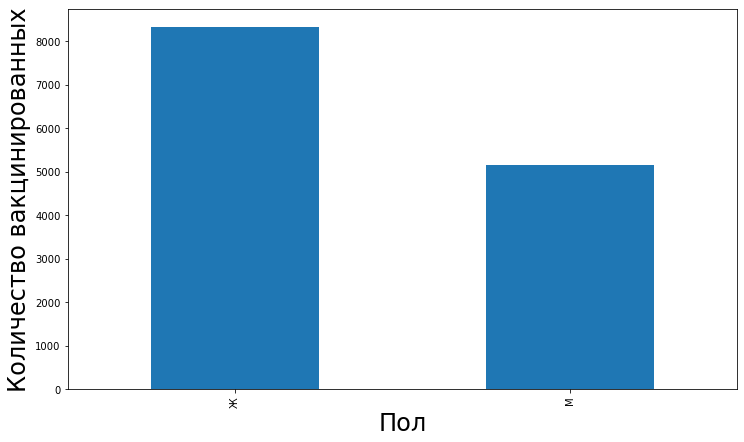

In [9]:
f = plt.figure(figsize=(12, 7))
plt.xlabel('Пол', fontsize=24)
plt.ylabel('Количество вакцинированных', fontsize=24)
messages['Gender'].value_counts().plot.bar()

<AxesSubplot:xlabel='Возраст', ylabel='Количество вакцинированных'>

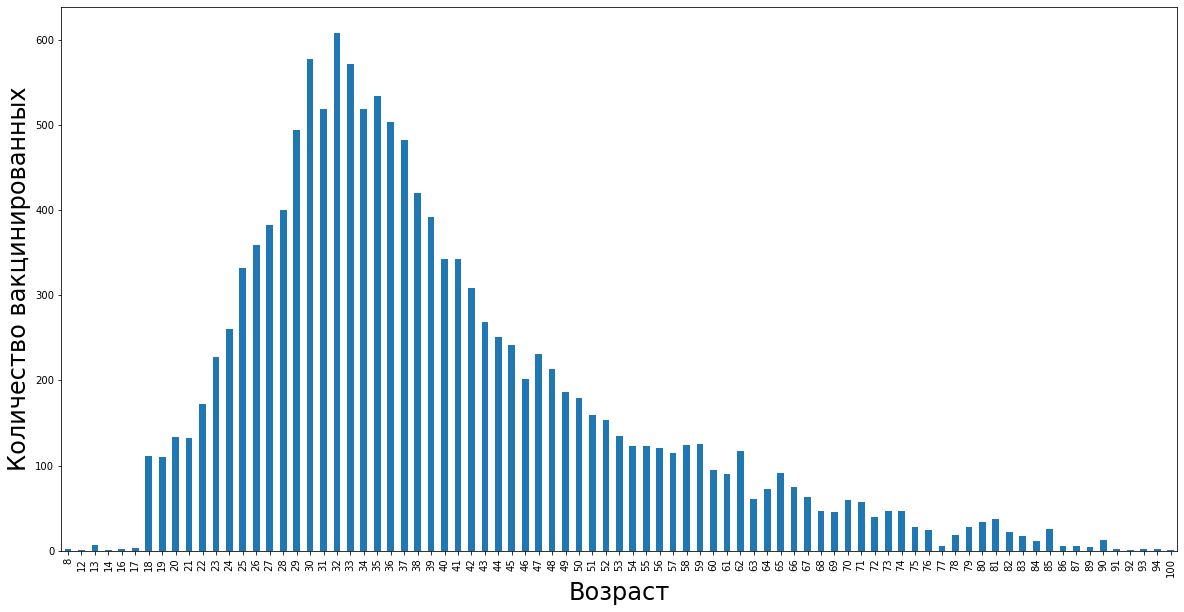

In [10]:
f = plt.figure(figsize=(20, 10))
plt.xlabel('Возраст', fontsize=24)
plt.ylabel('Количество вакцинированных', fontsize=24)
messages['Age'].value_counts().sort_index().plot.bar()

In [11]:
messages[['OE']] = messages['Text'].str.lower().str.extract(r'(\d+(?:\.\d+)?) oe', expand=True)
messages = messages.dropna()

# отбрасываем неидентифицированные строчки
messages = messages[messages.OE != '']

# выкидываем шумовое значение
messages = messages[messages.OE.astype('float') <= 1000] 
messages = messages.reset_index(drop=True)
messages.OE = messages.OE.astype('float')
#print(messages.OE)

Text(0, 0.5, 'Антитела, ОЕ/мл')

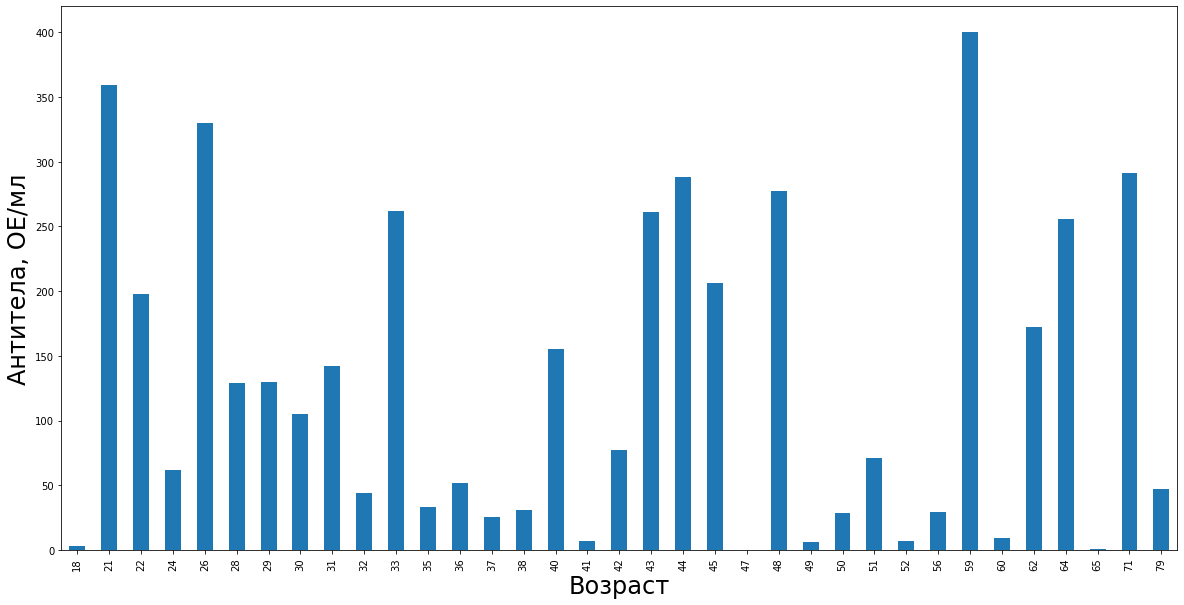

In [12]:
f = plt.figure(figsize=(20, 10))
messages.groupby('Age')['OE'].mean().plot.bar()
plt.xlabel('Возраст', fontsize=24)
plt.ylabel('Антитела, ОЕ/мл', fontsize=24)
